## Load dependencies

In [2]:
import time
from datetime import timedelta

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from unet.ml_models import UNet
from unet.ml_trainer import SetupTrainer
from unet.ml_dataset import UNetDataset, split_dataset, create_dataloaders, compute_mean_std
from unet.ml_criterions import FocalTverskyLoss
from unet.ml_metrics import IoUCoeff

## Define all parameters

In [3]:
# model
IN_CHANNELS = 1
OUT_CLASSES = 1

# Data
VALID_SIZE = 0.2
BATCH_SIZE = 8
AUGMENT = False
# Mean and std values are calculated based
# on benchmark_version3.hdf5
# MEAN = [0.6735]
# STD = [0.1342]

MEAN = [0.6795]
STD = [0.1417]
NUM_WORKERS = 0

# Optimizer
LEARN_RATE = 0.001

# Scheduler
LR_STEP_SIZE = 10
LR_DECAY_RATE = 0.1

# Loss function
ALPHA = 0.3
BETA = 0.7
GAMMA = 0.75

# Other hyperparameters
MAX_EPOCHS = 5
EARLY_STOP_PATIENCE = 10
MIN_CKP_ACC = 0.5

NUM_SAMPLES = None  # can be used for testing
USE_CUDA = True
PATH_OUT = "experiments"

## Data paths

In [4]:
hdf5_path = "data/segm_dataset.hdf5"
json_path = r"C:\Raghava_local\BENCHMARK_DATA\test"
png_path = "data/training_testing_set/training"

## Compute mean and std
- only if necessary

In [5]:
# mean, std = compute_mean_std(hdf5_path)
# MEAN = [mean]
# STD = [std]

## Create dataset objects

In [10]:
dataset_mode = "PNG"
data_path = png_path

if dataset_mode == "json":
    unet_dataset = UNetDataset.from_json_files(data_path, 
                                               augment=AUGMENT,
                                               mean=MEAN, std=STD, num_samples=NUM_SAMPLES)
elif dataset_mode == "hdf5":
    unet_dataset = UNetDataset.from_hdf5_data(data_path, augment=AUGMENT,
                                               mean=MEAN, std=STD, num_samples=NUM_SAMPLES)
else:
    unet_dataset = UNetDataset.from_png_files(data_path, augment=AUGMENT,
                                               mean=MEAN, std=STD, num_samples=NUM_SAMPLES)

data_dict = split_dataset(unet_dataset, VALID_SIZE)

print(data_dict["train"].__len__())
print(data_dict["valid"].__len__())

800
200


## Visualize data samples

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-4.795342445373535,2.2618210315704346]
Mask range: [0.0,1.0]


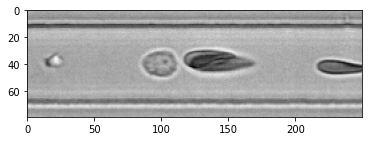

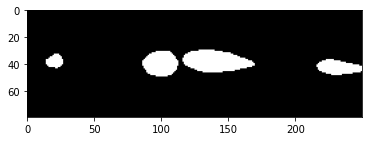

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-4.795342445373535,2.2618210315704346]
Mask range: [0.0,1.0]


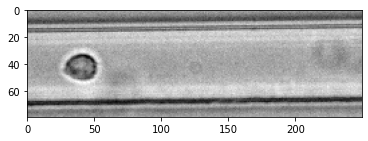

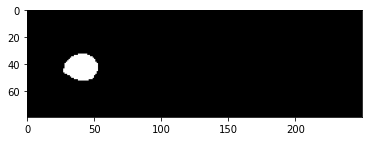

In [11]:
tds = data_dict["train"]
for i in range(2):
    img, msk = tds.__getitem__(i)
    print("Image shape:", img.shape)
    print("Mask shape:", msk.shape)
    print("Image range: [{},{}]".format(img.min(), img.max()))
    print("Mask range: [{},{}]".format(msk.min(), msk.max()))

    plt.imshow(img.permute(1, 2, 0), "gray")
    plt.show()
    plt.imshow(msk, "gray")
    plt.show()

## Create data loaders

In [12]:
dataloaders = create_dataloaders(data_dict, BATCH_SIZE, NUM_WORKERS)

In [24]:
print(len(dataloaders["train"].dataset))
print(len(dataloaders["valid"].dataset))

800
200


In [22]:
for n, (i, m) in enumerate(dataloaders["train"]):
    print('batch:', n)
    print(i.shape)

batch: 0
torch.Size([8, 1, 80, 250])
batch: 1
torch.Size([8, 1, 80, 250])
batch: 2
torch.Size([8, 1, 80, 250])
batch: 3
torch.Size([8, 1, 80, 250])
batch: 4
torch.Size([8, 1, 80, 250])
batch: 5
torch.Size([8, 1, 80, 250])
batch: 6
torch.Size([8, 1, 80, 250])
batch: 7
torch.Size([8, 1, 80, 250])
batch: 8
torch.Size([8, 1, 80, 250])
batch: 9
torch.Size([8, 1, 80, 250])
batch: 10
torch.Size([8, 1, 80, 250])
batch: 11
torch.Size([8, 1, 80, 250])
batch: 12
torch.Size([8, 1, 80, 250])
batch: 13
torch.Size([8, 1, 80, 250])
batch: 14
torch.Size([8, 1, 80, 250])
batch: 15
torch.Size([8, 1, 80, 250])
batch: 16
torch.Size([8, 1, 80, 250])
batch: 17
torch.Size([8, 1, 80, 250])
batch: 18
torch.Size([8, 1, 80, 250])
batch: 19
torch.Size([8, 1, 80, 250])
batch: 20
torch.Size([8, 1, 80, 250])
batch: 21
torch.Size([8, 1, 80, 250])
batch: 22
torch.Size([8, 1, 80, 250])
batch: 23
torch.Size([8, 1, 80, 250])
batch: 24
torch.Size([8, 1, 80, 250])
batch: 25
torch.Size([8, 1, 80, 250])
batch: 26
torch.Size([

## Create model

In [8]:
unet_model = UNet(n_channels=IN_CHANNELS, n_classes=OUT_CLASSES)

## Create criterion and metric

In [9]:
criterion = FocalTverskyLoss(alpha=ALPHA, beta=BETA, gamma=GAMMA)

metric = IoUCoeff()

## Create optimizer and scheduler

In [10]:
optimizer = Adam(unet_model.parameters(), lr=LEARN_RATE)

scheduler = lr_scheduler.StepLR(optimizer=optimizer,
                                step_size=LR_STEP_SIZE,
                                gamma=LR_DECAY_RATE)

## Set the trainer

In [11]:
trainer = SetTrainer(model=unet_model,
                     dataloaders=dataloaders,
                     criterion=criterion,
                     metric=metric,
                     optimizer=optimizer,
                     scheduler=scheduler,
                     max_epochs=MAX_EPOCHS,
                     use_cuda=USE_CUDA,
                     min_ckp_acc=MIN_CKP_ACC,
                     early_stop_patience=EARLY_STOP_PATIENCE,
                     path_out=PATH_OUT,
                     init_from_ckp=None
                     )

## Start Training

Started training.....
[Epochs-1/5 | lr:0.001]:
[Train_loss:0.7615 | Train_acc:0.1306 | Val_loss:0.7730 | Val_acc:0.3850]
[Epochs-2/5 | lr:0.001]:
[Train_loss:0.6375 | Train_acc:0.5031 | Val_loss:0.6173 | Val_acc:0.6000]
[Epochs-3/5 | lr:0.001]:
[Train_loss:0.5093 | Train_acc:0.6894 | Val_loss:0.4923 | Val_acc:0.5875]
[Epochs-4/5 | lr:0.001]:
[Train_loss:0.3787 | Train_acc:0.7812 | Val_loss:0.3602 | Val_acc:0.6725]
[Epochs-5/5 | lr:0.001]:
[Train_loss:0.2705 | Train_acc:0.8313 | Val_loss:0.2440 | Val_acc:0.7950]


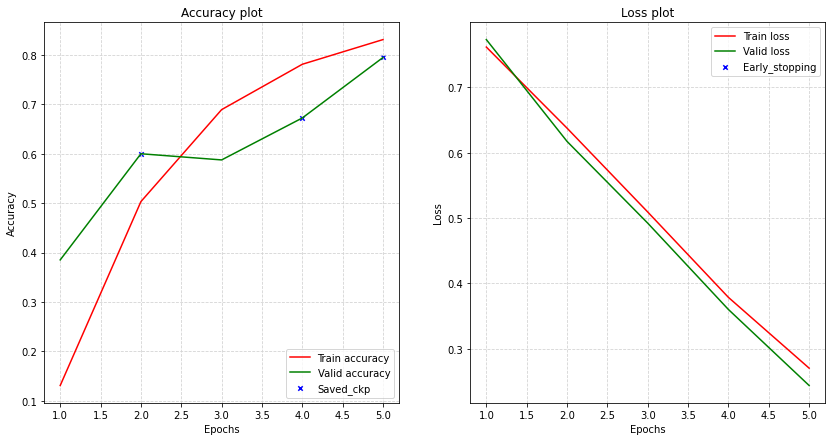

Total training time: 0:00:17


In [12]:
tik = time.time()
print("Started training.....")
trainer.strat_train()
tok = time.time() - tik
train_time = str(timedelta(seconds=tok)).split('.')[0]
print(f"Total training time: {train_time}")

## Image based inferencing

In [2]:
import dclab
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

from unet.inferencer import load_model, get_transformed_image
from unet.inferencer import get_unet_prediction

In [3]:
data_path = "data/test.rtdc"
model_path = "models/E38_validAcc_9838_jit.ckp"
use_cuda = True
num_imgs = 10
mean = 0.6735
std = 0.1342

In [4]:
dataset = dclab.new_dataset(data_path)
images = dataset['image']
image_bgs = dataset['image_bg']

unet = load_model(model_path, use_cuda=use_cuda)

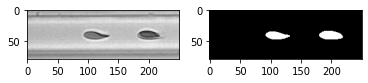

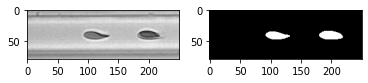

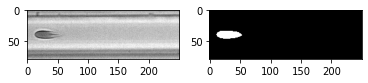

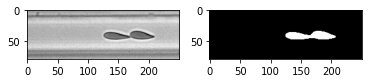

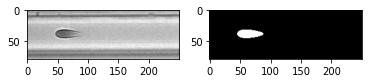

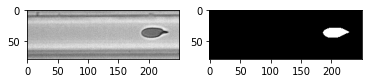

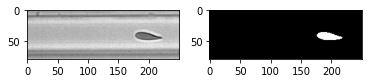

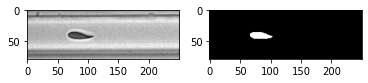

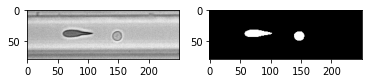

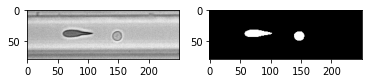

In [8]:
for i in range(num_imgs):
    img = images[i]
    img_tensor = get_transformed_image(img, mean, std)
    pred = get_unet_prediction(img_tensor, unet, use_cuda)

    thresh = threshold_otsu(pred)
    bin_pred = (pred > thresh)
    
    plt.subplot(121)
    plt.imshow(img, 'gray')
    plt.subplot(122)
    plt.imshow(bin_pred, 'gray')
    plt.show()
